# Fraud Detection Model

In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score
)

In [47]:
df = pd.read_csv('C:/Users/ACER/fraud-detection/data/creditcard.csv')
df.shape

(284807, 31)

# 1. Exploratory Data Analysis (EDA)

## 1.1 Distribusi Fraud vs Normal

Text(0.5, 1.0, 'Distribution of Transactions (0=Normal, 1=Fraud)')

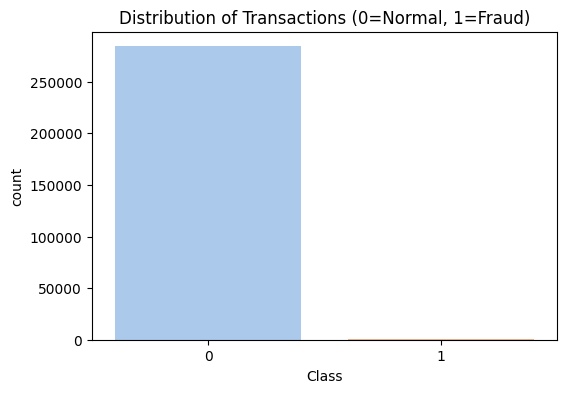

In [48]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['Class'], hue=df['Class'], palette='pastel', legend=False)
plt.title('Distribution of Transactions (0=Normal, 1=Fraud)')

## 1.2 Waktu Kejadian Fraud

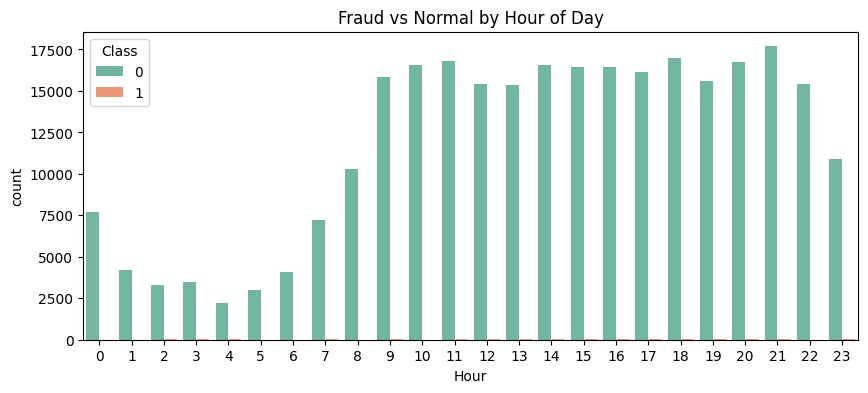

In [49]:
# Bikin kolom jam dari detik
df['Hour'] = (df['Time'] // 3600) % 24
df['Hour'] = df['Hour'].astype(int)

plt.figure(figsize=(10,4))
sns.countplot(x='Hour', hue='Class', data=df, palette='Set2')
plt.title('Fraud vs Normal by Hour of Day')
plt.legend(title='Class')

Text(0.5, 1.0, 'Fraud Transactions by Hour of Day')

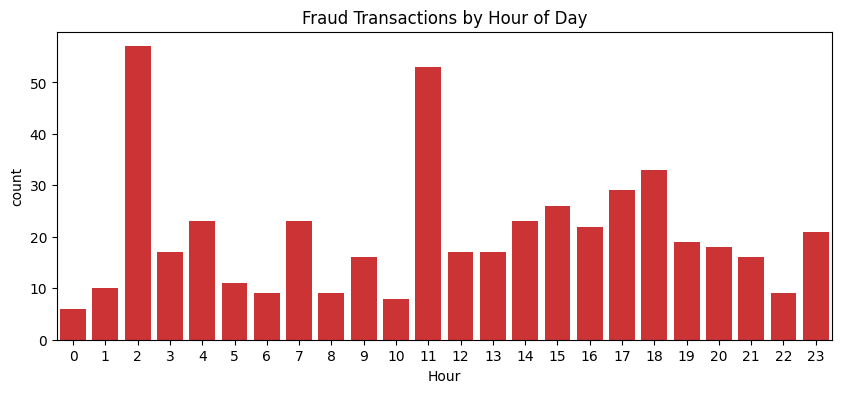

In [50]:
plt.figure(figsize=(10,4))
sns.countplot(x='Hour', hue='Class', data=df[df['Class']==1], legend=False, palette='Set1')
plt.title('Fraud Transactions by Hour of Day')

## 1.3 Fitur Paling Membedakan Fraud vs Non‑Fraud

Text(0, 0.5, 'Feature')

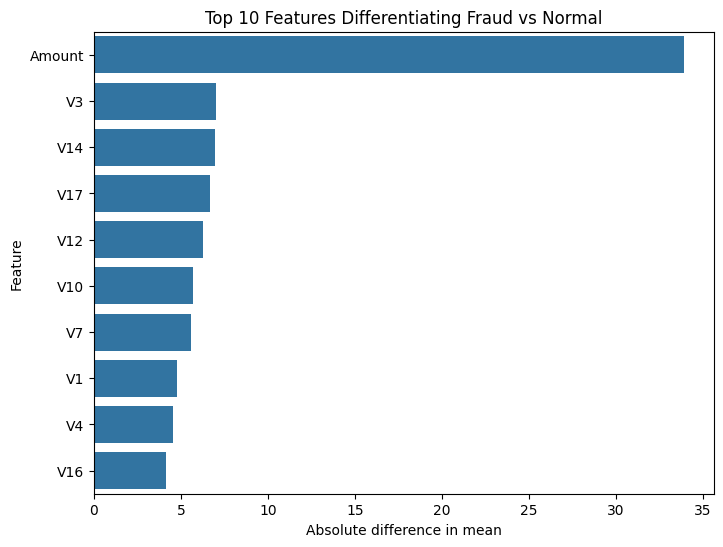

In [51]:
# Hitung mean per fitur untuk fraud dan normal
# Drop kolom 'Time' sebelum menghitung mean per kelas
df_for_mean = df.drop(columns=['Time'])

# Hitung mean per fitur untuk fraud dan normal menggunakan dataframe tanpa 'Time'
means = df_for_mean.groupby('Class').mean().T
means['diff'] = abs(means[1] - means[0])
top_feats = means['diff'].sort_values(ascending=False).head(10).index

# Ambil data yang sesuai dan urutkan berdasarkan 'diff'
plot_data = means.reset_index().loc[means.reset_index()['index'].isin(top_feats)]
plot_data = plot_data.sort_values(by='diff', ascending=False)  # agar bar dari bawah ke atas

plt.figure(figsize=(8,6))
sns.barplot(x='diff', y='index', data=plot_data)
plt.title('Top 10 Features Differentiating Fraud vs Normal')
plt.xlabel('Absolute difference in mean')
plt.ylabel('Feature')

# 2. Preprocessing

## 2.1 Handle Missing Values

In [52]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
Hour      0
dtype: int64

In [53]:
df.dropna(inplace=True)

## 2.2 Normalisasi Jumlah Transaksi

In [54]:
scaler = StandardScaler()
df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])

## 2.3 Handling Imbalance (SMOTE)

In [55]:
X = df.drop(columns=['Time', 'Class', 'Hour', 'Amount'])
y = df['Class']

# SMOTE oversampling pada train set saja
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts(normalize=True))
print("After  SMOTE:", y_train_res.value_counts(normalize=True))

Before SMOTE: Class
0    0.998271
1    0.001729
Name: proportion, dtype: float64
After  SMOTE: Class
0    0.5
1    0.5
Name: proportion, dtype: float64


# 3. Modeling

In [56]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# 4. Evaluation

In [57]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"Classification Report for {model_name}:")
    print(classification_report(y_test, y_pred, digits=4))

    print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
    print(f"Average Precision Score (PR AUC): {average_precision_score(y_test, y_proba):.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_test, y_proba):.4f})')

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure()
    plt.plot(recall, precision, label=f'{model_name} (AP = {average_precision_score(y_test, y_proba):.4f})')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {model_name}")
    plt.legend()
    plt.show()

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0     0.9999    0.9734    0.9865     56864
           1     0.0562    0.9184    0.1059        98

    accuracy                         0.9733     56962
   macro avg     0.5280    0.9459    0.5462     56962
weighted avg     0.9982    0.9733    0.9849     56962

ROC AUC Score: 0.9700
Average Precision Score (PR AUC): 0.7237


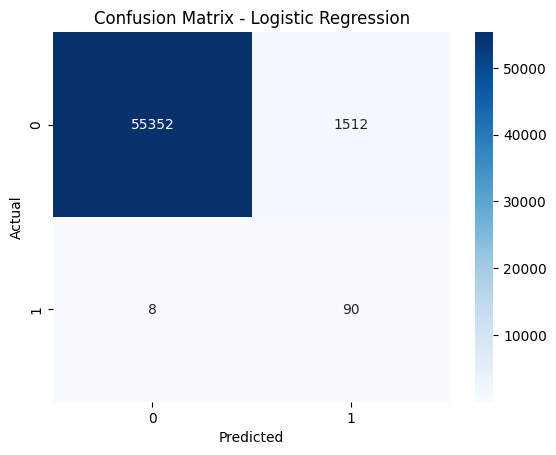

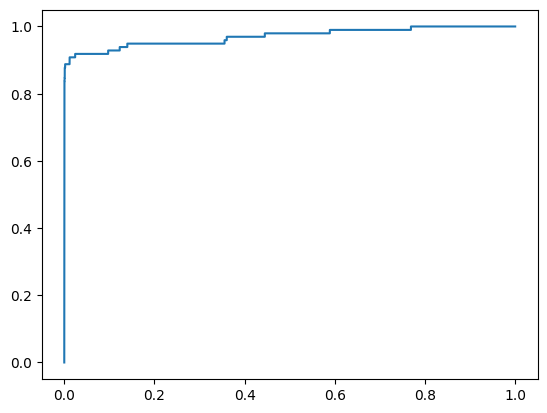

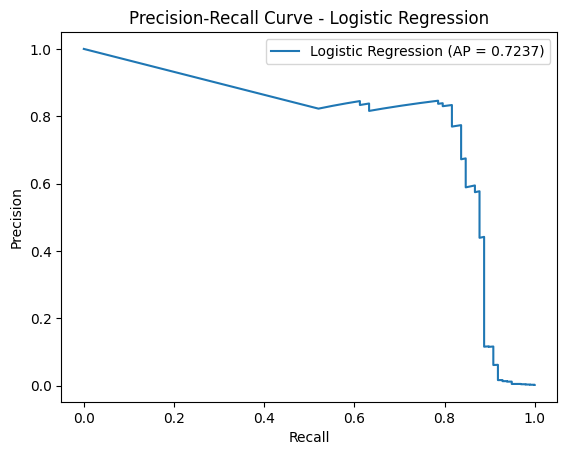

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0     0.9997    0.9997    0.9997     56864
           1     0.8247    0.8163    0.8205        98

    accuracy                         0.9994     56962
   macro avg     0.9122    0.9080    0.9101     56962
weighted avg     0.9994    0.9994    0.9994     56962

ROC AUC Score: 0.9741
Average Precision Score (PR AUC): 0.8569


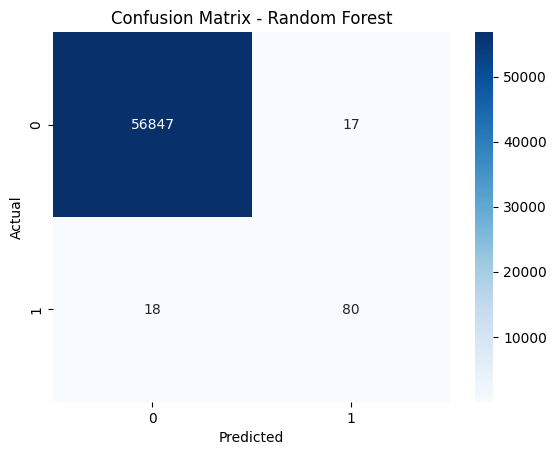

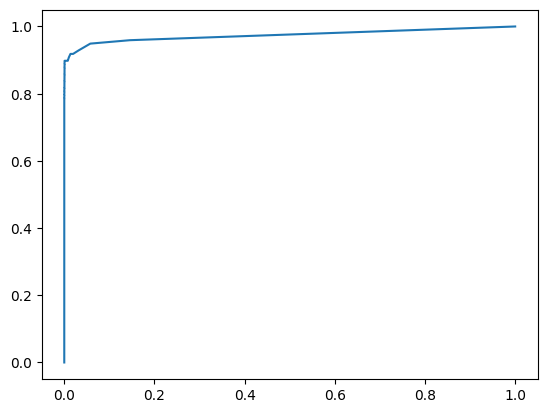

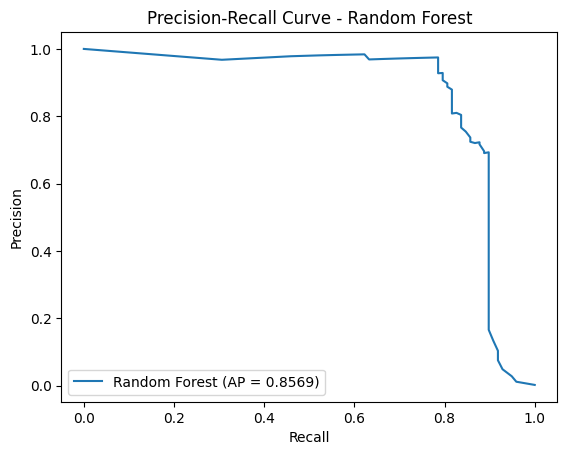

d:\Users\ACER\anaconda3\envs\fraud-env\lib\site-packages\xgboost\core.py:158: UserWarning: [22:33:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Classification Report for XGBoost:
              precision    recall  f1-score   support

           0     0.9998    0.9993    0.9995     56864
           1     0.6855    0.8673    0.7658        98

    accuracy                         0.9991     56962
   macro avg     0.8426    0.9333    0.8827     56962
weighted avg     0.9992    0.9991    0.9991     56962

ROC AUC Score: 0.9753
Average Precision Score (PR AUC): 0.8737


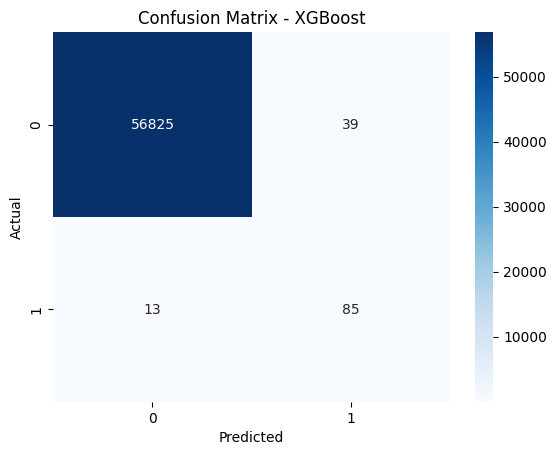

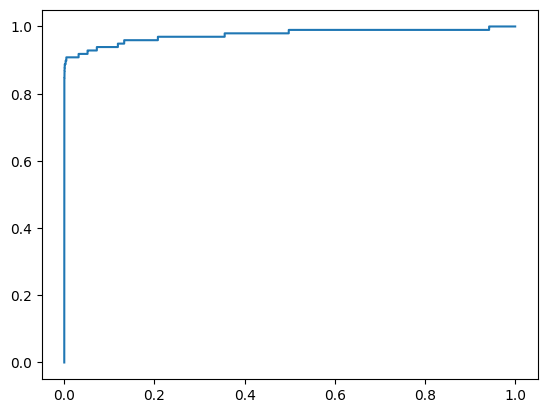

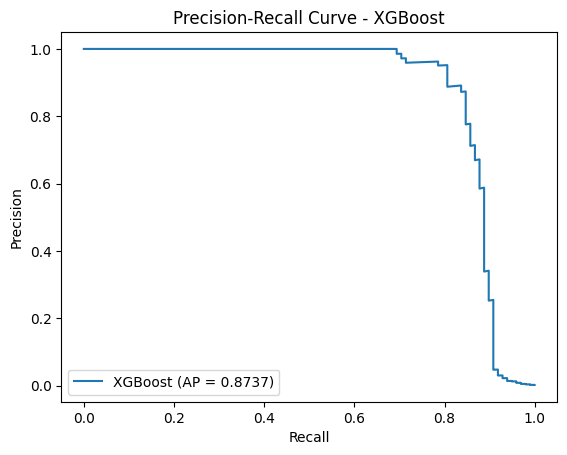

In [58]:
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    evaluate_model(model, X_test, y_test, name)

In [60]:
import joblib

best_model = models["XGBoost"]
joblib.dump(best_model, '../models/model.pkl')
joblib.dump(scaler, '../models/preprocessing.pkl')

['../models/preprocessing.pkl']

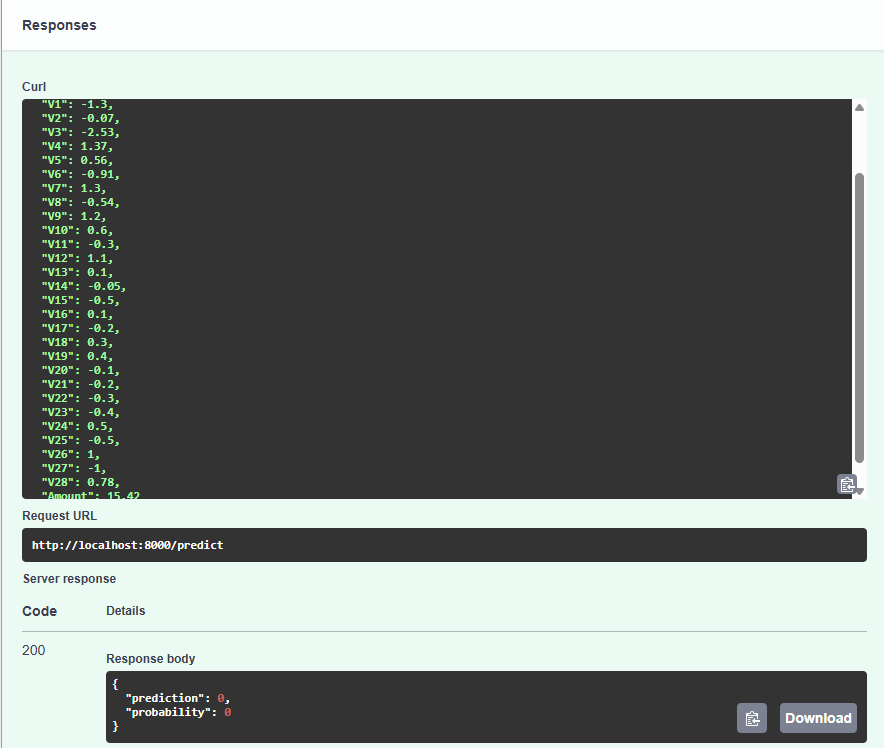